# Análisis de ventas globales de videojuegos y perfil de usuarios

# Descripción del proyecto

Trabajas para la tienda online Ice que vende videojuegos por todo el mundo. Las reseñas de usuarios y expertos, los géneros, las plataformas (por ejemplo, Xbox o PlayStation) y los datos históricos sobre las ventas de juegos están disponibles en fuentes abiertas. Tienes que identificar patrones que determinen si un juego tiene éxito o no. Esto te permitirá detectar proyectos prometedores y planificar campañas publicitarias.

Delante de ti hay datos que se remontan a 2016. Imaginemos que es diciembre de 2016 y estás planeando una campaña para 2017.

Lo importante es adquirir experiencia de trabajo con datos. Realmente no importa si estás pronosticando las ventas de 2017 en función de los datos de 2016 o las ventas de 2027 en función de los datos de 2026.

El dataset contiene una columna "rating" que almacena la clasificación ESRB de cada juego. El Entertainment Software Rating Board (la Junta de clasificación de software de entretenimiento) evalúa el contenido de un juego y asigna una clasificación de edad como Adolescente o Adulto.

##  Inicialización

In [5]:
# Cargarmos librerias.

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats as st
import seaborn as sns 


## Cargar datos

In [7]:
# Cargamos los archivos de datos.
games = pd.read_csv('games.csv')

## Preparar los datos

In [9]:
# Vista previa de los datos.
games.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [10]:
# Vista previa de los datos.
games.info()
print()
print('Filas duplicadas en el dataframe:', games.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB

Filas duplicadas en el dataframe: 0


In [11]:
# Remplazamos los nombres de las columnas todo a minusculas. 
games.columns = games.columns.str.lower()

In [12]:
# Imputamos valores ausentes con 'desconocido' 
games['name'].fillna('Desconocido', inplace=True)
games['genre'].fillna('Desconocido', inplace=True)
games['rating'].fillna('Desconocido', inplace=True)

/var/folders/y8/f0jgdbxx0ln8rkqv0wph8qnw0000gn/T/ipykernel_53607/2435756576.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  games['name'].fillna('Desconocido', inplace=True)
/var/folders/y8/f0jgdbxx0ln8rkqv0wph8qnw0000gn/T/ipykernel_53607/2435756576.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alw

In [13]:
# Convertimos la columna year_of_realease a int, los valores ausentes son llenados con '0'.
games['year_of_release'] = games['year_of_release'].fillna(0).astype(int)

In [14]:
# Convertimos la columna user_score los valores 'tbd' a valores nulos y convertimos el tipo de dato a float.
games.loc[games['user_score'] == 'tbd', 'user_score'] = np.nan
games['user_score'] = games['user_score'].astype(float)

In [15]:
# Los valores ausentes son tratados como '-1' similar a la columna years_of_release decidimos utilizar un valor muy bajo.
games['user_score'].fillna(-1, inplace=True)
games['critic_score'].fillna(-1, inplace=True)

/var/folders/y8/f0jgdbxx0ln8rkqv0wph8qnw0000gn/T/ipykernel_53607/228178323.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  games['user_score'].fillna(-1, inplace=True)
/var/folders/y8/f0jgdbxx0ln8rkqv0wph8qnw0000gn/T/ipykernel_53607/228178323.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always beh

In [16]:
# Creamos una columna con las ventas totales para enriquecer nuestros datos.
games['total_sales'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']

columnas = ['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'total_sales', 'critic_score', 'user_score', 'rating']
games = games[columnas]


**Notas:**

Esta preparación deja el dataset en una forma adecuada para realizar análisis exploratorio de datos (EDA), visualizaciones y modelado sin problemas con datos faltantes o formatos inconsistentes.

- Los campos name, genre y rating se han llenado con la etiqueta "Desconocido" para valores ausentes. En year_of_release, los valores nulos se llenaron con 0. Para las columnas user_score y critic_score, se asignó el valor -1 para representar valores desconocidos, lo cual permite identificar datos ausentes sin afectar las métricas promedio y facilita la interpretación en análisis posteriores.
- Estandarización de Columnas: Los nombres de las columnas se han convertido a minúsculas para un formato uniforme, lo que facilita su manipulación y visualización.
- Conversión de Tipos de Datos: year_of_release se ha convertido a int, asignando 0 a valores desconocidos. user_score y critic_score se han convertido a float y los valores 'tbd' se transformaron en NaN antes de ser imputados.
- Creamos una columna con las ventas totales para enriquecer nuestros datos.

##  Analizamos los datos

### Cuántos juegos fueron lanzados en diferentes años

In [20]:
# Visualizaremos cuantos juegos fueron lanzados por cada año.
games_by_year = games.groupby('year_of_release').count()['name'].sort_values().reset_index() 
games_by_year = games_by_year.query('year_of_release != 0')

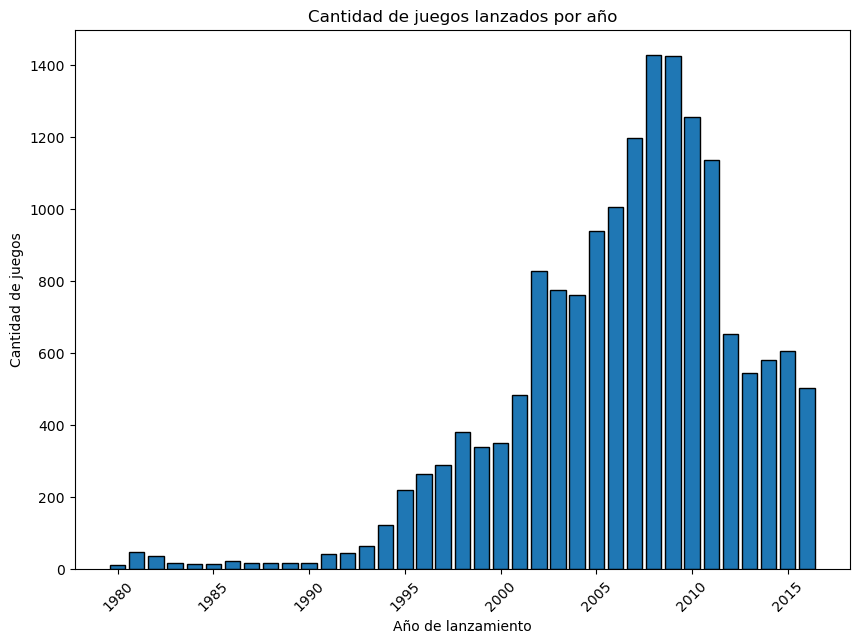

In [21]:
# creamos un grafico de barras para vizualizar la cantidad de juegos lanzados por año.
plt.figure(figsize=(10, 7)) 
plt.bar(games_by_year['year_of_release'], games_by_year['name'], edgecolor='black')  
plt.xlabel('Año de lanzamiento')  
plt.ylabel('Cantidad de juegos')  
plt.title('Cantidad de juegos lanzados por año') 
plt.xticks(rotation=45) 
plt.show()  

**Notas:** después de 2009, se observa una disminución en el número de lanzamientos de juegos. Esto puede ser debido a varios factores, como el cambio hacia plataformas de juegos móviles, el aumento de costos de desarrollo en consolas de última generación, y el cambio en el modelo de negocio hacia juegos como servicio, donde se ofrecen actualizaciones y expansiones en lugar de lanzar nuevos juegos.

### Observa cómo varían las ventas de una plataforma a otra

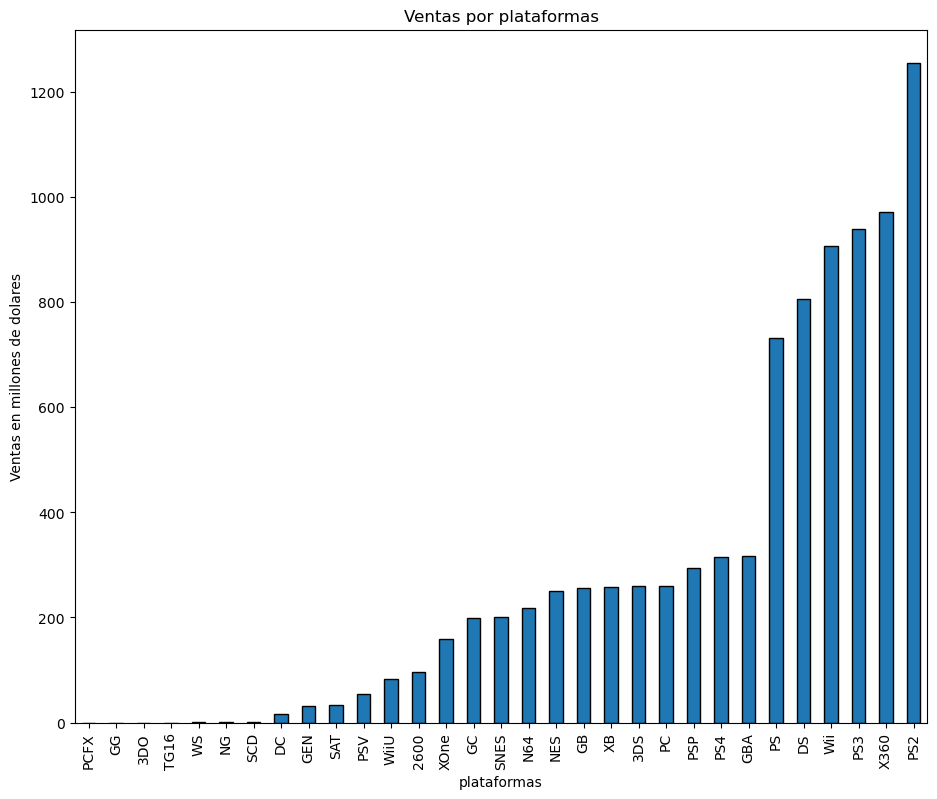

In [24]:
# Observaremos como varian las ventas de una plataforma a otra.
ventas_por_plataforma = games.groupby('platform')['total_sales'].sum().sort_values()

#Graficamos.
ventas_por_plataforma.plot(kind='bar', figsize=(11,9), title='Ventas por plataformas', ylabel='Ventas en millones de dolares', xlabel='plataformas',
                          edgecolor='black')
plt.show()


**Notas:** Las plataformas con mayores ventas acumuladas en el mercado global de videojuegos son PS2, X360, PS3, Wii y DS, superando ampliamente los 900 millones de dólares cada una. Este resultado refleja el dominio de Sony, Microsoft y Nintendo en la industria durante sus generaciones más exitosas.

### Ventas de las plataformas mas populares por año

In [27]:
# Analizaremos las ventas totales anuales de las 10 plataformas con mas ventas.

top_platforms = games.groupby('platform')['total_sales'].sum().nlargest(10).index
filtered_games = games[games['platform'].isin(top_platforms)]
filtered_games = filtered_games.query('year_of_release != 0')
platform_sales_by_year = filtered_games.groupby(['year_of_release', 'platform'])['total_sales'].sum().unstack()

<function matplotlib.pyplot.show(close=None, block=None)>

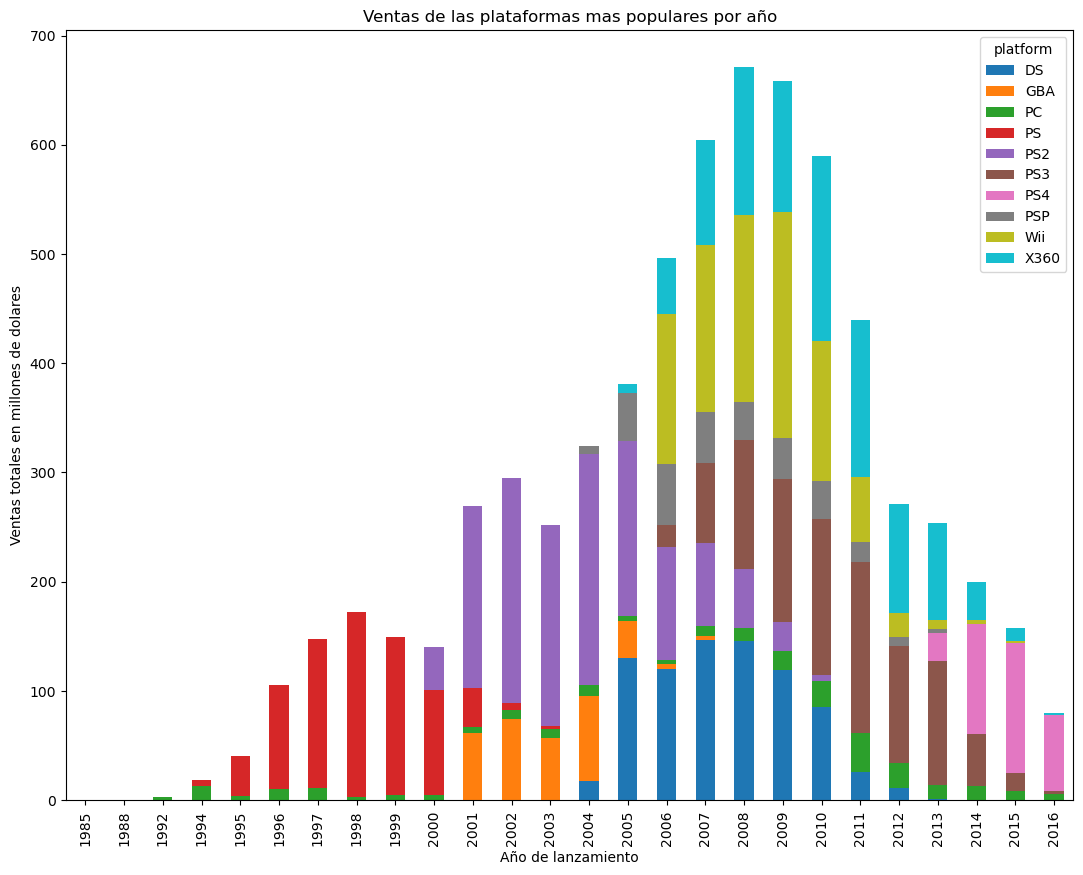

In [28]:
platform_sales_by_year.plot(kind='bar', stacked=True, figsize=(13, 10))
plt.title('Ventas de las plataformas mas populares por año')
plt.xlabel('Año de lanzamiento')
plt.ylabel('Ventas totales en millones de dolares')
plt.show

**Notas:** En este gráfico de barras apiladas, se observa cómo las ventas de distintas plataformas varían a lo largo de los años. Algunas conclusiones que se pueden extraer son:

período de popularidad para una plataforma importante parece durar entre 5 y 10 años, después de lo cual se observa un declive en las ventas a medida que surgen nuevas tecnologías y plataformas.
Esto sugiere que una plataforma tarda unos pocos años en alcanzar su máxima popularidad y luego se mantiene durante varios años antes de declinar.

A partir de 2014, muchas de estas plataformas desaparecen o sus ventas son mínimas, probablemente debido a la introducción de consolas de nueva generación y la introduccion de venta de video juegos en linea.

### Construir un modelo para 2017

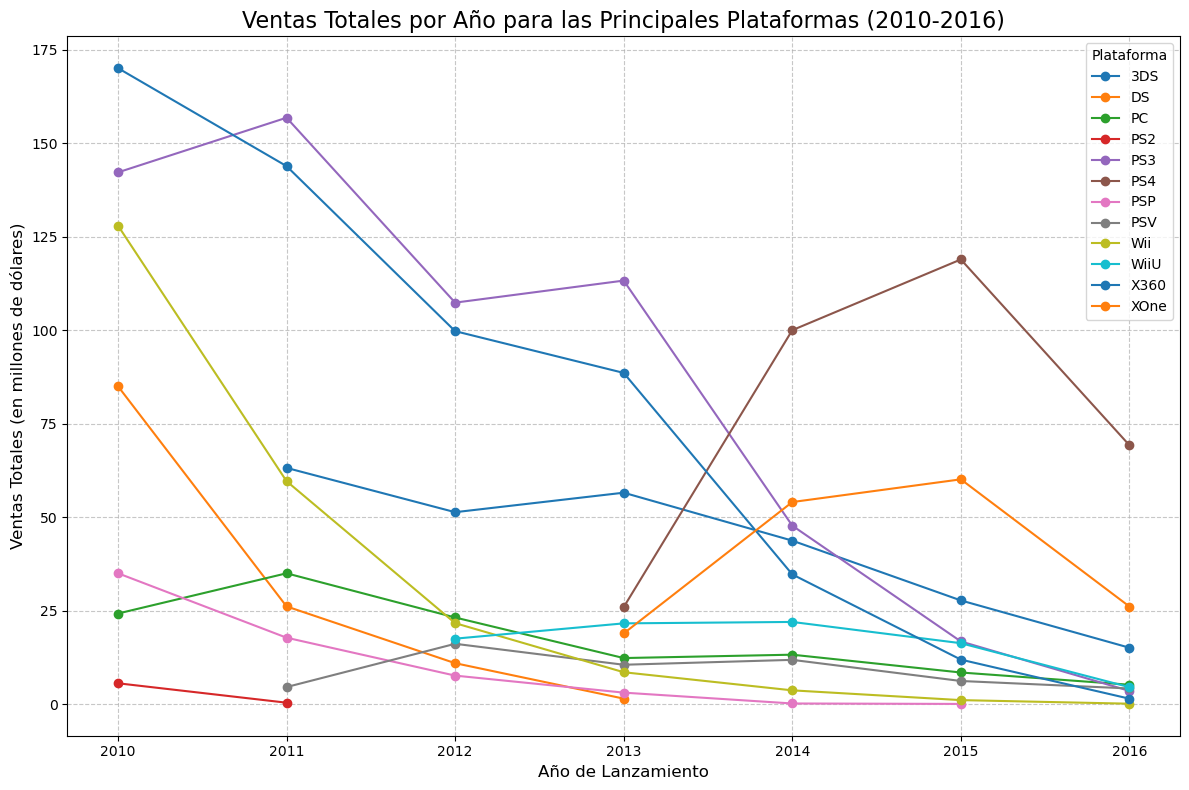

In [31]:
# Determinamos que utilizaremos datos del 2009 al 2016 para poder construir un modelo para 2017.
games_er = games.groupby(['platform', 'year_of_release'])['total_sales'].sum().reset_index()
games_er = games_er.query('year_of_release > 2009')
top_platforms = (games_er.groupby('platform')['total_sales'].sum().index)
top_platforms_sales = games_er[games_er['platform'].isin(top_platforms)].reset_index()
pivot_data = top_platforms_sales.pivot(index='year_of_release', columns='platform', values='total_sales')

# Graficamos.
pivot_data.plot(kind='line', figsize=(12, 8), marker='o')
plt.title('Ventas Totales por Año para las Principales Plataformas (2010-2016)', fontsize=16)
plt.xlabel('Año de Lanzamiento', fontsize=12)
plt.ylabel('Ventas Totales (en millones de dólares)', fontsize=12)
plt.legend(title="Plataforma", fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

**Notes:** La PS4 y XOne son las principales plataformas que muestran crecimiento a partir de su lanzamiento. La PS4 destaca especialmente por su crecimiento rápido, lo que indica su potencial como una plataforma rentable para futuras inversiones en juegos y contenido.

Reducción: La PS3, X360, y Wii muestran una clara disminución en ventas a lo largo de los años, ya que estas consolas estaban siendo reemplazadas por nuevas generaciones (PS4 y XOne).

En resumen, las plataformas PS4, 3DS, y XOne parecen ser las opciones más prometedoras para generar ingresos en 2017, con la PS4 liderando en términos de crecimiento y ventas.

### Diagrama de caja para las ventas globales de todos los juegos

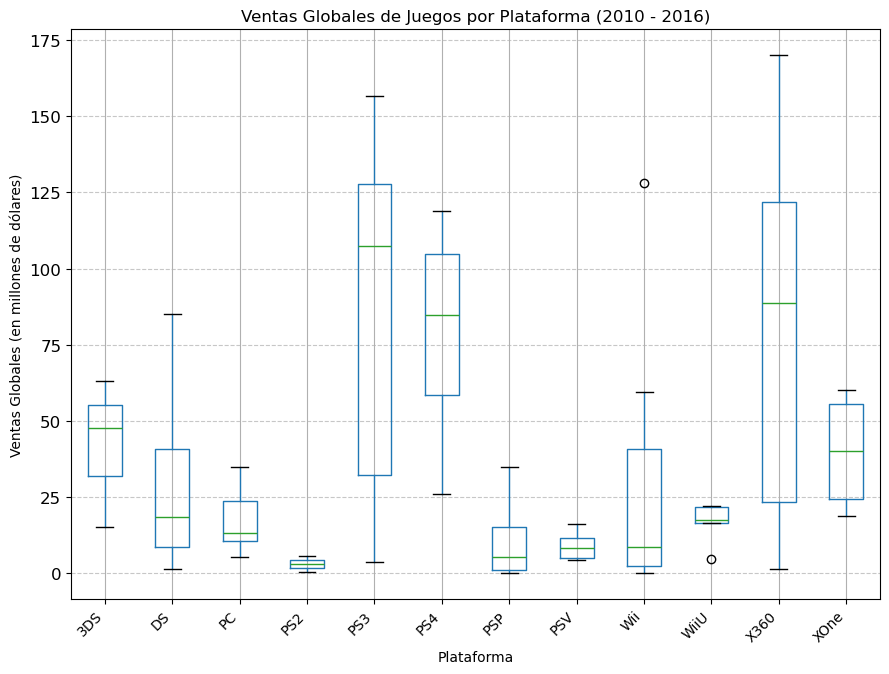

In [34]:
# Crearemos un diagrama de caja para las ventas globales de todos los juegos, desglosados por plataforma.

top_platforms_sales.boxplot(column='total_sales', by='platform', figsize=(9,7))
plt.title('Ventas Globales de Juegos por Plataforma (2010 - 2016)')
plt.suptitle('')
plt.xlabel('Plataforma')
plt.ylabel('Ventas Globales (en millones de dólares)')
plt.xticks(rotation=45, ha='right')
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**Notas:** Plataformas Potencialmente Rentables: PS4, PS3, XOne, 3DS y X360 son las plataformas más rentables, con medianas más altas y una variabilidad considerable, lo que sugiere que pueden albergar títulos muy exitosos.
Plataformas Menos Rentables: PC, PSV, y WiiU tienen medianas bajas y menos variabilidad, lo cual sugiere que tienen menos probabilidad de albergar juegos de alto éxito, haciéndolas menos atractivas para nuevas inversiones en títulos importantes.
Éxitos Ocasionales: A pesar de tener menores ventas promedio, plataformas como Wii y WiiU tienen algunos éxitos destacados, posiblemente gracias a títulos exclusivos o franquicias populares.
En resumen, PS4, PS3, XOne, 3DS y X360 se destacan como opciones atractivas para lanzamientos de nuevos juegos debido a su historial de ventas altas y variabilidad, lo que sugiere un mercado amplio y con potencial de altos ingresos.

### Gráfico de dispersión y calcula la correlación entre las reseñas y las ventas

Text(0, 0.5, 'Ventas Totales (millones de dólares)')

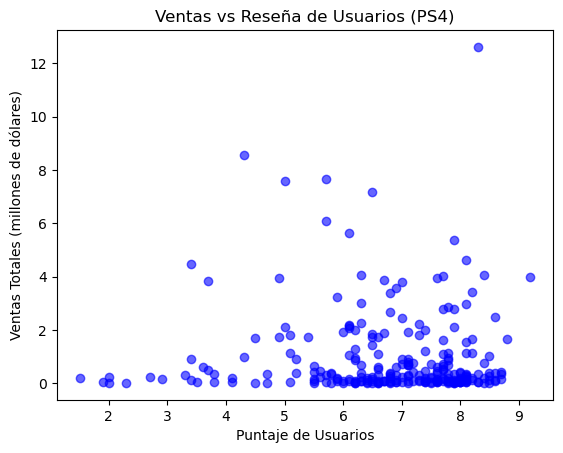

In [37]:
# Crearemos un gráfico de dispersión de la plataforma PS4 y calcularemos la correlación entre las reseñas y las ventas.

ps4_data = games[games['platform'] == 'PS4']
ps4_data = ps4_data.query('user_score != -1')
ps4_data = ps4_data.query('critic_score != -1')
plt.scatter(ps4_data['user_score'], ps4_data['total_sales'], alpha=0.6, color='blue')
plt.title('Ventas vs Reseña de Usuarios (PS4)')
plt.xlabel('Puntaje de Usuarios')
plt.ylabel('Ventas Totales (millones de dólares)')

Text(0, 0.5, 'Ventas Totales (millones de dólares)')

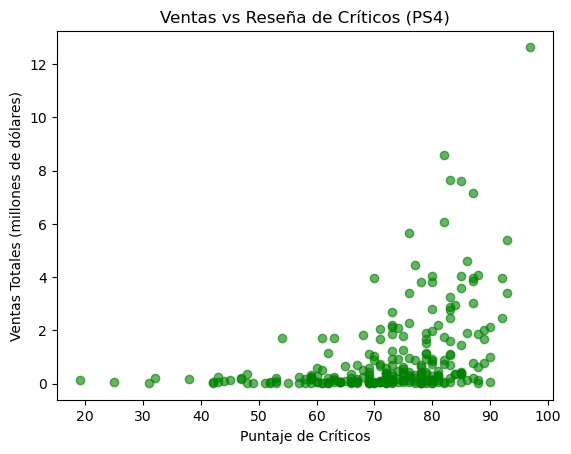

In [39]:

plt.scatter(ps4_data['critic_score'], ps4_data['total_sales'], alpha=0.6, color='green')
plt.title('Ventas vs Reseña de Críticos (PS4)')
plt.xlabel('Puntaje de Críticos')
plt.ylabel('Ventas Totales (millones de dólares)')

In [40]:
user_sales_corr = ps4_data['user_score'].corr(ps4_data['total_sales'])
critic_sales_corr = ps4_data['critic_score'].corr(ps4_data['total_sales'])

In [41]:
print(user_sales_corr)
print(critic_sales_corr)

-0.0336249759652888
0.4058948014583667


**Notas:** La correlación entre las reseñas de usuarios y las ventas es de aproximadamente -0.03, lo cual indica una relación negativa muy débil.
Esto sugiere que las puntuaciones de los usuarios no tienen una influencia significativa en las ventas. En otras palabras, el éxito comercial de un juego en la PS4 no parece depender de si los usuarios le dan una puntuación alta o baja.


La correlación entre las reseñas de críticos y las ventas es de aproximadamente 0.41, lo cual indica una relación positiva moderada.
Esto sugiere que las puntuaciones de los críticos tienen una cierta influencia en las ventas. Es posible que los juegos con mejores reseñas de críticos tengan mayores probabilidades de éxito en ventas, aunque esta relación no es lo suficientemente fuerte como para considerarla determinante.

### Distribución general de los juegos por género

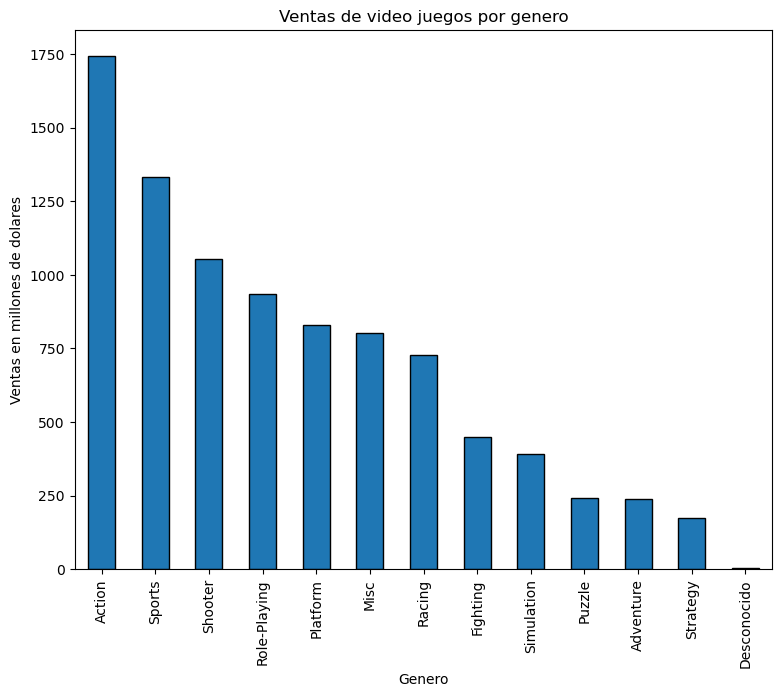

In [110]:
# haremos una distribucion general de los juegos por genero para saber que generos generan mas ventas.
genre_counts = games['genre'].value_counts()
genre_sales = games.groupby('genre')['total_sales'].sum().sort_values(ascending=False)

#Graficamos.
genre_sales.plot(kind='bar', figsize=(9, 7), title='Ventas de video juegos por genero', xlabel='Genero', ylabel='Ventas en millones de dolares' , edgecolor='black')
plt.show()

**Notas:** Los géneros de acción, deportes, y shooters suelen tener una mayor aceptación y, por lo tanto, mayores ingresos, probablemente debido a su atractivo universal y su capacidad para captar una audiencia amplia.
Los géneros con ventas bajas parecen ser menos populares o más orientados a nichos específicos. Aunque pueden tener seguidores leales, es probable que estos géneros no generen el mismo nivel de ingresos que los géneros más populares.

## Creamos un perfil de usuario para cada región

### Las cinco plataformas principales para cada región

In [47]:
# Para cada región (NA, UE, JP) determinaremos las 5 plataformas principales

top_platforms_na = games.groupby('platform')['na_sales'].sum().nlargest(5)
top_platforms_eu = games.groupby('platform')['eu_sales'].sum().nlargest(5)
top_platforms_jp = games.groupby('platform')['jp_sales'].sum().nlargest(5)

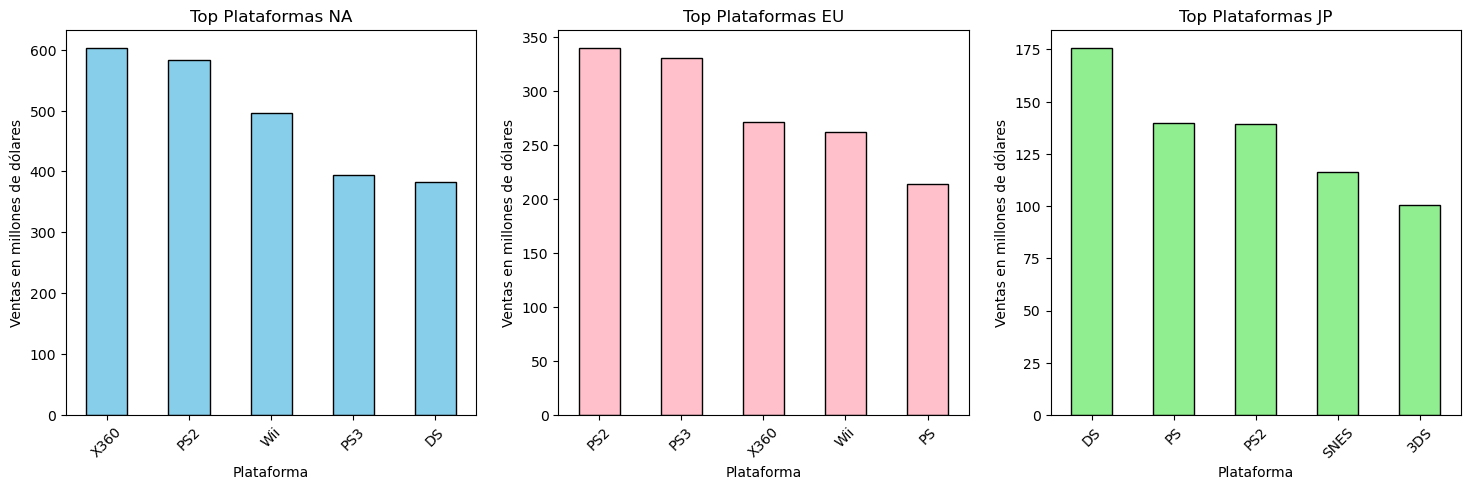

In [115]:

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
top_platforms_na.plot(kind='bar', color='skyblue', edgecolor='black', title='Top Plataformas NA')
plt.xlabel('Plataforma')
plt.ylabel('Ventas en millones de dólares')
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
top_platforms_eu.plot(kind='bar', color='pink', edgecolor='black', title='Top Plataformas EU')
plt.xlabel('Plataforma')
plt.ylabel('Ventas en millones de dólares')
plt.xticks(rotation=45)

plt.subplot(1, 3, 3)
top_platforms_jp.plot(kind='bar', color='lightgreen', edgecolor='black', title='Top Plataformas JP')
plt.xlabel('Plataforma')
plt.ylabel('Ventas en millones de dólares')
plt.xticks(rotation=45)

plt.show()

**Notas:** 

Norteamérica (NA): Principales plataformas: X360, PS2, Wii, PS3, y DS.
La Xbox 360 domina en NA, posiblemente debido al atractivo de juegos exclusivos y una buena aceptación en el mercado norteamericano.

Europa (EU): Principales plataformas: PS2, PS3, X360, Wii, y PS.
La PlayStation tiene una presencia fuerte en Europa, con la PS2 y PS3 entre las plataformas más vendidas, lo que indica una mayor afinidad por las consolas de Sony en comparación con América del Norte.

Japón (JP): Principales plataformas: DS, PS, PS2, SNES, y 3DS.
Japón muestra una preferencia significativa por plataformas portátiles como Nintendo DS y 3DS. Además, las consolas clásicas como la PS y SNES tienen una presencia relevante, reflejando una preferencia cultural por plataformas de Nintendo y Sony.

### Los cinco géneros principales

In [121]:
# Visualizaremos los 5 generos principales de cada region (Na, EU, JP).

top_genre_na = games.groupby('genre')['na_sales'].sum().nlargest(5)
top_genre_eu = games.groupby('genre')['eu_sales'].sum().nlargest(5)
top_genre_jp = games.groupby('genre')['jp_sales'].sum().nlargest(5)

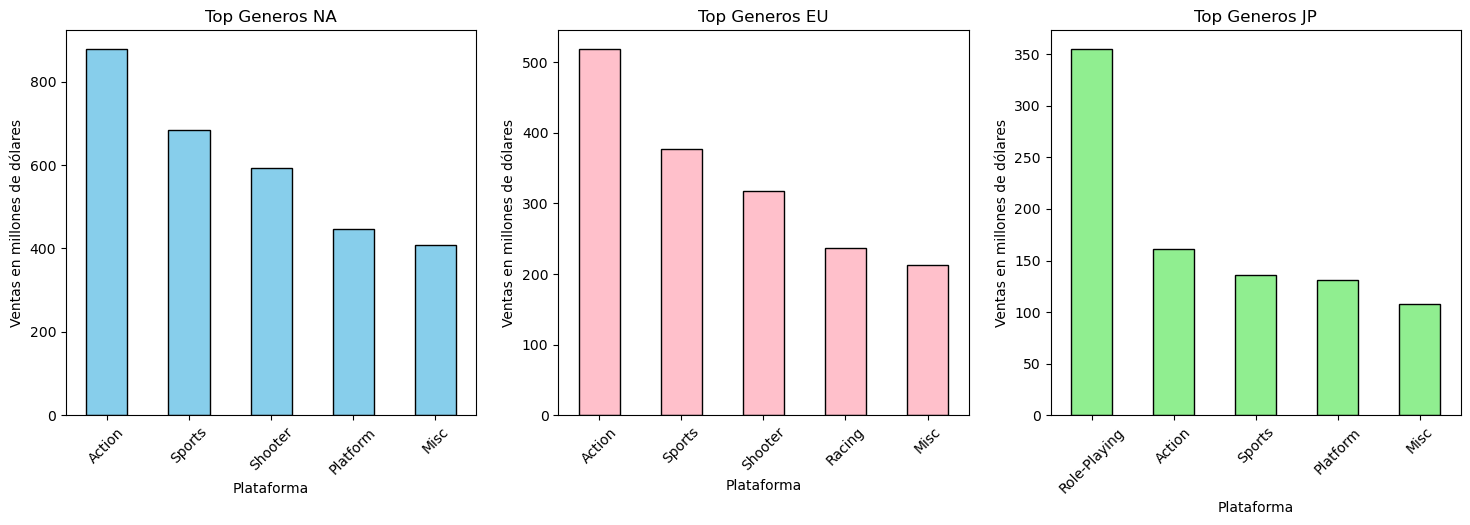

In [135]:
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
top_genre_na.plot(kind='bar', color='skyblue', edgecolor='black' , title='Top Generos NA')
plt.xlabel('Plataforma')
plt.ylabel('Ventas en millones de dólares')
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
top_genre_eu.plot(kind='bar', color='pink', edgecolor='black', title='Top Generos EU')
plt.xlabel('Plataforma')
plt.ylabel('Ventas en millones de dólares')
plt.xticks(rotation=45)

plt.subplot(1, 3, 3)
top_genre_jp.plot(kind='bar', color='lightgreen', edgecolor='black', title='Top Generos JP')
plt.xlabel('Plataforma')
plt.ylabel('Ventas en millones de dólares')
plt.xticks(rotation=45)

plt.show()

**Notas:** 

NA y EU tienen preferencias similares, con el género Action dominando en ambas regiones, seguido de Sports y Shooter.

JP muestra una preferencia única por Role-Playing, lo cual refleja las diferencias culturales en el mercado de videojuegos, con un enfoque en géneros que ofrecen historias complejas y experiencias inmersivas.

Este análisis puede ser útil para entender cómo adaptar estrategias de marketing y desarrollo de videojuegos en función de las preferencias de cada región.

### ¿ESRB (Entertainment Software Rating Board)  afectan a las ventas en regiones individuales?

In [53]:
# Analizaremos si las clasificaciones de ESRB afectan a las ventas en regiones individuales.

esrb_na = games.groupby('rating')['na_sales'].sum().sort_values(ascending=False)
esrb_eu = games.groupby('rating')['eu_sales'].sum().sort_values(ascending=False)
esrb_jp = games.groupby('rating')['jp_sales'].sum().sort_values(ascending=False)

esrb_na_filtered = esrb_na.reset_index().query('rating != "Desconocido"').set_index('rating')
esrb_eu_filtered = esrb_eu.reset_index().query('rating != "Desconocido"').set_index('rating')
esrb_jp_filtered = esrb_jp.reset_index().query('rating != "Desconocido"').set_index('rating')

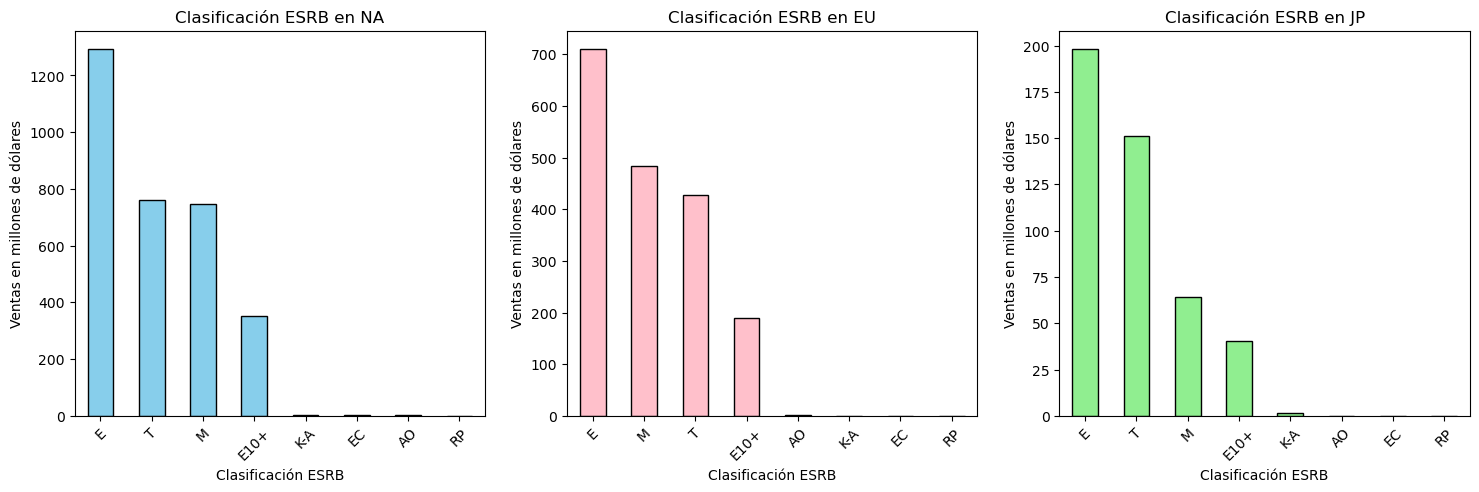

In [146]:
plt.figure(figsize=(18, 5))

ax1 = plt.subplot(1, 3, 1)
esrb_na_filtered.plot(kind='bar', color='skyblue', edgecolor='black', legend=False, ax=ax1)
ax1.set_title('Clasificación ESRB en NA')
ax1.set_xlabel('Clasificación ESRB')
ax1.set_ylabel('Ventas en millones de dólares')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)

ax2 = plt.subplot(1, 3, 2)
esrb_eu_filtered.plot(kind='bar', color='pink', edgecolor='black', legend=False, ax=ax2)
ax2.set_title('Clasificación ESRB en EU')
ax2.set_xlabel('Clasificación ESRB')
ax2.set_ylabel('Ventas en millones de dólares')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)

ax3 = plt.subplot(1, 3, 3)
esrb_jp_filtered.plot(kind='bar', color='lightgreen', edgecolor='black', legend=False, ax=ax3)
ax3.set_title('Clasificación ESRB en JP')
ax3.set_xlabel('Clasificación ESRB')
ax3.set_ylabel('Ventas en millones de dólares')
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45)

plt.show()


**Notas:** E (Everyone) es la clasificación dominante en todas las regiones, indicando una fuerte preferencia global por juegos aptos para todas las edades.
Mature (M) y Teen (T) son populares en NA y EU, mientras que en Japón los juegos para adolescentes (T) son más populares que los de contenido maduro (M).
Las clasificaciones E10+ y las clasificaciones extremadamente específicas como AO y EC tienen poca relevancia en todas las regiones, lo que sugiere que estos juegos tienen un mercado reducido o limitado.

## Prueba de hipótesis 

 ### Hipótesis 1: Comparación de las Calificaciones Promedio entre Xbox One y PC

Criterio para Probar la Hipótesis
Usaremos una prueba t de dos muestras (o prueba t de Student) porque:

Queremos comparar las medias de dos grupos independientes (calificaciones de usuarios de Xbox One vs. PC).
Asumimos que las calificaciones de usuario para cada plataforma son distribuidas aproximadamente de manera normal, dado el tamaño del dataset.
Antes de realizar la prueba t, también aplicamos una prueba de Levene para comprobar si las varianzas de las dos plataformas son iguales. Esto nos permite decidir si usar la prueba t con varianzas iguales (equal_var=True) o desiguales (equal_var=False).

H0: las clasificaciones promedio de los usuarios de XboxOne y PC son estadisticamente significativas, es decir, son iguales.

H1: las clasificaciones promedio de los usuarios de XboxOne y PC No son estadisticamente significativas, es decir, no son iguales.



In [164]:
# # Mostrar los resultados de la prueba de Levene

alpha = 0.05
xbox_one_score = games[(games['platform'] == 'XOne') & (games['user_score'] != -1)]['user_score']
pc_score = games[(games['platform'] == 'PC') & (games['user_score'] != -1)]['user_score']

p_value_levene = st.levene(xbox_one_score, pc_score)
print(p_value_levene)
print()

if (p_value_levene.pvalue < alpha):
    print('Rechazamos H0: La varianza de Xbox One no es igual a la varianza de PC')
else:
    print('No podemos rechazar H0, no hay evidencia suficiente para decir que la varianza de Xbox One y PC no son iguales')
    


LeveneResult(statistic=1.2212506384014863, pvalue=0.26939515120472823)

No podemos rechazar H0, no hay evidencia suficiente para decir que la varianza de Xbox One y PC no son iguales


In [61]:
# Verificaremos si las calificaciones promedio de los usuarios para las plataformas Xbox One y PC son las mismas.

result_xbox_pc = st.ttest_ind(xbox_one_score, pc_score, equal_var=True).pvalue
print(result_xbox_pc)
print()

if (result_xbox_pc < alpha):
    print('Rechazamos la hipotesis nula')
else:
    print('No podemos rechazar la hipotesis nula')


1.3896435533548827e-05

Rechazamos la hipotesis nula


**Conclusion:**

Al rechazar la hipótesis nula, concluimos que las calificaciones promedio de los usuarios para las plataformas Xbox One y PC son significativamente diferentes. Este resultado indica que existe una diferencia estadísticamente significativa entre las calificaciones promedio de los usuarios en ambas plataformas, y no es probable que esta diferencia sea solo producto del azar.

Interpretación
Este hallazgo sugiere que los usuarios de Xbox One y PC evalúan los juegos de manera diferente en promedio, lo que puede ser útil para comprender las preferencias o expectativas distintas entre los jugadores de estas plataformas.

### Hipótesis 2: Comparación de las Calificaciones Promedio entre Géneros de Acción y Deportes


Para probar esta hipótesis, nuevamente usaremos una prueba t de dos muestras. El criterio para elegir esta prueba es el mismo que en la primera hipótesis:

Comparamos las medias de dos grupos independientes (calificaciones de usuario para los géneros de Acción vs. Deportes).
Si las varianzas son iguales (según la prueba de Levene), utilizaremos equal_var=True; de lo contrario, usaremos equal_var=False.

H0: Las calificaciones promedio de los usuarios para los géneros de Acción y Deportes son iguales.

H1: Las calificaciones promedio de los usuarios para los géneros de Acción y Deportes son diferentes.

In [66]:
# # Mostrar los resultados de la prueba de Levene

alpha = 0.05
accion = games[(games['genre'] == 'Action') & (games['user_score'] != -1)]['user_score']
deportes = games[(games['genre'] == 'Sports') & (games['user_score'] != -1)]['user_score']

levene_action_sports = st.levene(accion, deportes)
print(levene_action_sports)
print()

if (levene_action_sports.pvalue < alpha):
    print('Rechazamos H0: La varianza de Action no es igual a la varianza de Sports')
else:
    print('No podemos rechazar H0, no hay evidencia suficiente para decir que la varianza de Action y Sports no son iguales')

LeveneResult(statistic=14.132896085177192, pvalue=0.00017366406727275597)

Rechazamos H0: La varianza de Action no es igual a la varianza de Sports


In [67]:
# Verificaremos si las calificaciones promedio de los usuarios para Action y Sports son las mismas.

result_action_sports = st.ttest_ind(accion, deportes, equal_var=False).pvalue
print(result_action_sports)
print()

if (result_action_sports < alpha):
    print('Rechazamos la hipotesis nula')
else:
    print('No podemos rechazar la hipotesis nula')

0.11483818791498293

No podemos rechazar la hipotesis nula


**Conclusion:**
    
Aunque las varianzas de las calificaciones entre los géneros de Acción y Deportes son diferentes, las calificaciones promedio de los usuarios para estos géneros no muestran una diferencia estadísticamente significativa.
Esto sugiere que, en promedio, los usuarios califican los juegos de Acción y Deportes de manera similar, a pesar de la variabilidad en las calificaciones dentro de cada género.
Este análisis es importante para entender que, aunque los géneros puedan tener distribuciones de calificaciones diferentes (como muestra la prueba de Levene), las medias de las calificaciones pueden ser estadísticamente similares.    

## Conclusión general

Este análisis ofrece una perspectiva detallada sobre el comportamiento de los usuarios en el mercado global de videojuegos, observando diferencias regionales, preferencias de género y variaciones de calificaciones por plataforma. A continuación, se destacan los hallazgos clave:

Preferencias Regionales:

Los géneros y plataformas populares varían significativamente entre Norteamérica, Europa y Japón. Las plataformas de Microsoft y Sony dominan en Occidente, mientras que Japón muestra una clara preferencia por las consolas portátiles y los géneros de rol. Esto sugiere que los desarrolladores deben adaptar sus estrategias según el mercado objetivo.

Impacto de la Clasificación ESRB:

Los juegos clasificados como E (Everyone) son populares en todas las regiones, lo que indica una preferencia global por juegos accesibles a una audiencia amplia. Sin embargo, las clasificaciones más restrictivas, como M (Mature), tienen un mayor impacto en NA y EU que en JP, lo que muestra diferencias culturales en la aceptación de contenido para adultos.

Análisis de las Calificaciones de Usuario:

Aunque existen diferencias de calificaciones entre las plataformas, como entre Xbox One y PC, estas no son significativas en cuanto a las medias. En el caso de los géneros, aunque Acción y Deportes muestran varianzas diferentes en las calificaciones, no se observan diferencias significativas en las calificaciones promedio, lo que indica una percepción globalmente similar en términos de calidad y disfrute de estos géneros.

Implicaciones Estratégicas:

La información obtenida puede orientar futuras decisiones en desarrollo, marketing y posicionamiento de videojuegos. En particular, entender que las diferencias de preferencias y aceptación de contenido entre regiones y plataformas es esencial para una planificación eficaz en el lanzamiento de juegos.

Este proyecto reafirma la importancia de analizar datos de ventas y calificaciones en profundidad, para comprender mejor las demandas y expectativas del mercado global de videojuegos. La combinación de un análisis estadístico riguroso y una comprensión de las preferencias regionales permite una visión más clara y fundamentada para decisiones estratégicas en la industria.